In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import mnist_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible

In [4]:
X_train, X_val, y_train, y_val = mnist_prep()

In [5]:
# use samller dataset for increased speed
X_train_small = X_train[:1000, :]
X_val_small = X_val[:500, :]
y_train_small = y_train[:1000]
y_val_small = y_val[:500]

n_cols = X_train_small.shape[1]

# EnKF

In [6]:
X_train = X_train_small
X_test = X_val_small
y_train = y_train_small
y_test = y_val_small

In [7]:
batch_size = 50
epochs = 10
particles = 10
early_stopping = False
early_stopping_diff = 0.001
batch_normal = False # evtl. noch einbauen, obwohl im Paper nicht gemacht (aber Achtung mit den Dimensionen unten!!!)
shuffle = True
randomization = True

In [8]:
layers = 5
neurons = [128, 128, 64, 32, 10]
n_cols = X_train.shape[1]

In [9]:
delta = 0.005
h_0 = 2
epsilon = 0.5

In [10]:
n = len(X_train)
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [11]:
indices = y_train.sample(frac=1).index
indices

Int64Index([521, 737, 740, 660, 411, 678, 626, 513, 859, 136,
            ...
            121, 614,  20, 700,  71, 106, 270, 860, 435, 102],
           dtype='int64', length=1000)

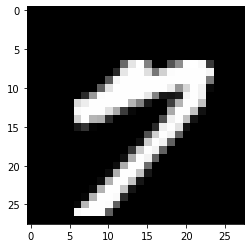

In [12]:
from tensorflow.keras.datasets import mnist
(X_tr, y_tr), (X_te, y_te) = mnist.load_data()

import matplotlib.pyplot as plt

sample = 0
image = X_tr[indices[sample]]
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

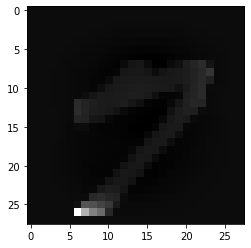

7

In [13]:
import matplotlib.pyplot as plt

sample = 0
image = X_train[indices].reshape(1000, 28, 28)[sample]
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

y_train.iloc[indices].reset_index(drop = True).iloc[sample].argmax()

In [14]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_acc_dict = {}
test_acc_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [15]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_acc_dict["model_{}".format(str(i+1))] = []
    test_acc_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [16]:
model_1 = nn_model_structure(layers = layers,
                             neurons = neurons,
                             n_cols = n_cols)
model_1 = nn_model_compile(model_1,
                           optimizer = "sgd")
model_1.set_weights(model_dict["model_1"].get_weights())

model_2 = nn_model_structure(layers = layers,
                             neurons = neurons,
                             n_cols = n_cols)
model_2 = nn_model_compile(model_2,
                           optimizer = "sgd")
model_2.set_weights(model_dict["model_2"].get_weights())

model_3 = nn_model_structure(layers = layers,
                             neurons = neurons,
                             n_cols = n_cols)
model_3 = nn_model_compile(model_3,
                           optimizer = "sgd")
model_3.set_weights(model_dict["model_3"].get_weights())

model_4 = nn_model_structure(layers = layers,
                             neurons = neurons,
                             n_cols = n_cols)
model_4 = nn_model_compile(model_4,
                           optimizer = "sgd")
model_4.set_weights(model_dict["model_4"].get_weights())

model_5 = nn_model_structure(layers = layers,
                             neurons = neurons,
                             n_cols = n_cols)
model_5 = nn_model_compile(model_5,
                           optimizer = "sgd")
model_5.set_weights(model_dict["model_5"].get_weights())

In [17]:
# mean_model as the model with the mean of the weights of all particle models
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
mean_model = init_model
mean_model.set_weights(mean_weights)

mean_model_train_acc = np.array(mean_model.evaluate(X_train, y_train)[1])
mean_model_test_acc = np.array(mean_model.evaluate(X_test, y_test)[1])

16/16 [==============================] - 0s 976us/step - loss: 2.3035 - accuracy: 0.0900


In [18]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_val_small, y_val_small)[1])

16/16 [==============================] - 0s 978us/step - loss: 2.3805 - accuracy: 0.1140
0.11400000005960464
16/16 [==============================] - 0s 976us/step - loss: 2.4470 - accuracy: 0.0700
0.07000000029802322
16/16 [==============================] - 0s 974us/step - loss: 2.3891 - accuracy: 0.0820
0.0820000022649765
16/16 [==============================] - 0s 502us/step - loss: 2.4278 - accuracy: 0.1240
0.12399999797344208
16/16 [==============================] - 0s 976us/step - loss: 2.4027 - accuracy: 0.1060
0.10599999874830246
16/16 [==============================] - 0s 504us/step - loss: 2.4314 - accuracy: 0.0720
0.07199999690055847
16/16 [==============================] - 0s 0s/step - loss: 2.3707 - accuracy: 0.0920
0.09200000017881393
16/16 [==============================] - 0s 976us/step - loss: 2.5079 - accuracy: 0.0680
0.06800000369548798
16/16 [==============================] - 0s 975us/step - loss: 2.4219 - accuracy: 0.1140
0.11400000005960464
16/16 [================

In [19]:
import time
start_time = time.time()

In [20]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [X_train[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]   
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            jacobian_dict["model_{}".format(str(i+1))] = (-1) * np.multiply(np.array(y_batches[b]), 
                                                                            np.array(1 / (y_pred_dict["model_{}".format(str(i+1))] + delta)))
            
            # for every particle write the training accuracy of the current iteration in a dictionary
            train_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_train, y_train, verbose = 0)[1])
            
            # for every particle write the test accuracy of the current iteration in a dictionary
            test_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_test, y_test, verbose = 0)[1])
            
            # for every particle write the current iteration in a dictionary
            iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
        
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.sum(np.multiply(y_pred_centered, jacobian_dict["model_{}".format(str(j+1))]))
                                       
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
          
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
            if randomization:
                # add randomization/ noise to each particle
                new_weights = []
                # standard deviation for scaled Glorot distribution
                for s in range(len(shapes)):
                    if shapes[s].shape[0] == 2:
                        fan_in = shapes[s][0]
                        fan_out = shapes[s][1]
                    if shapes[s].shape[0] == 1:
                        fan_in = shapes[s-1][0]
                        fan_out = shapes[s][0]
                    stddev = np.sqrt(np.sqrt(h_t)) * np.sqrt(2 / (fan_in + fan_out))
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = tuple(shapes[s]))
                    new_weights.append(weights_dict["model_{}".format(str(i+1))][s] + noise)
                weights_dict["model_{}".format(str(i+1))] = new_weights
                
    if randomization:
        # randomize particles around their mean
        weights_mean = list(np.mean(list(weights_dict.values()), axis = 0))
        for i in range(particles):
            new_weights = []
            # standard deviation for Glorot distribution
            for s in range(len(shapes)):
                if shapes[s].shape[0] == 2:
                    fan_in = shapes[s][0]
                    fan_out = shapes[s][1]
                if shapes[s].shape[0] == 1:
                    fan_in = shapes[s-1][0]
                    fan_out = shapes[s][0]
                stddev = np.sqrt(2 / (fan_in + fan_out))
                noise = np.random.normal(loc = 0.0,
                                         scale = stddev,
                                         size = tuple(shapes[s]))
                new_weights.append(weights_mean[s] + noise)
            weights_dict["model_{}".format(str(i+1))] = new_weights
            
    # update the mean_model
    mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
    mean_model.set_weights(mean_weights)
    
    mean_model_train_acc = np.append(mean_model_train_acc, np.array(mean_model.evaluate(X_train, y_train, verbose = 0)[1]))
    mean_model_test_acc = np.append(mean_model_test_acc, np.array(mean_model.evaluate(X_test, y_test, verbose = 0)[1]))
    
    # early stopping
    if early_stopping:
        if epoch == 0:
            test_acc_old = 0
        else:
            test_acc_new = mean_model_test_acc[epoch]
            if np.absolute(test_acc_new - test_acc_old) <= early_stopping_diff:
                print("STOP: Early Stopping after epoch {} because improvement in test accuracy is only {}."\
                                                                     .format(epoch+1, test_acc_new - test_acc_old))
                break
            test_acc_old = test_acc_new

In [21]:
end_time = time.time()
print("Calculation time: {}".format(end_time - start_time))

Calculation time: 265.1229717731476


In [22]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_val_small, y_val_small)[1])

16/16 [==============================] - 0s 976us/step - loss: 2.3154 - accuracy: 0.0800
0.07999999821186066
16/16 [==============================] - 0s 976us/step - loss: 2.5279 - accuracy: 0.0960
0.09600000083446503
16/16 [==============================] - 0s 977us/step - loss: 1675.8927 - accuracy: 0.0640
0.06400000303983688
16/16 [==============================] - 0s 975us/step - loss: 2.3039 - accuracy: 0.1300
0.12999999523162842
16/16 [==============================] - 0s 977us/step - loss: 66.2598 - accuracy: 0.0720
0.07199999690055847
16/16 [==============================] - 0s 2ms/step - loss: 2.3159 - accuracy: 0.1140
0.11400000005960464
16/16 [==============================] - 0s 976us/step - loss: 253.4883 - accuracy: 0.0860
0.0860000029206276
16/16 [==============================] - 0s 979us/step - loss: 2.3834 - accuracy: 0.0680
0.06800000369548798
16/16 [==============================] - 0s 977us/step - loss: 13463.4268 - accuracy: 0.0680
0.06800000369548798
16/16 [=====

In [23]:
model_dict

{'model_1': <tensorflow.python.keras.engine.sequential.Sequential at 0x1d3a1a68c48>,
 'model_2': <tensorflow.python.keras.engine.sequential.Sequential at 0x1d3a1a93688>,
 'model_3': <tensorflow.python.keras.engine.sequential.Sequential at 0x1d3a1ac5848>,
 'model_4': <tensorflow.python.keras.engine.sequential.Sequential at 0x1d3a15e6748>,
 'model_5': <tensorflow.python.keras.engine.sequential.Sequential at 0x1d3a193b408>,
 'model_6': <tensorflow.python.keras.engine.sequential.Sequential at 0x1d3a154f948>,
 'model_7': <tensorflow.python.keras.engine.sequential.Sequential at 0x1d39a220208>,
 'model_8': <tensorflow.python.keras.engine.sequential.Sequential at 0x1d3a194bbc8>,
 'model_9': <tensorflow.python.keras.engine.sequential.Sequential at 0x1d3a2ad0848>,
 'model_10': <tensorflow.python.keras.engine.sequential.Sequential at 0x1d3a2aee448>}

In [24]:
model_dict["model_1"].get_weights()

[array([[-0.02418994, -0.00907256,  0.01614682, ...,  0.01122   ,
         -0.01013403, -0.01105018],
        [ 0.01396614,  0.00136955, -0.00636482, ...,  0.0381516 ,
         -0.04752008, -0.01923188],
        [ 0.02001091, -0.01349107, -0.00205047, ...,  0.00676866,
         -0.00034171, -0.03875785],
        ...,
        [ 0.00567199,  0.03490168,  0.00317805, ..., -0.03668525,
          0.00553792, -0.02611743],
        [-0.02363296,  0.03533082, -0.01467183, ...,  0.0155682 ,
          0.02458116,  0.03527067],
        [ 0.01247646, -0.00016244, -0.01942199, ..., -0.00151792,
         -0.04178212,  0.00018865]], dtype=float32),
 array([ 2.05219090e-02,  1.38903968e-02,  1.27042225e-02, -3.61487865e-02,
        -1.47671271e-02,  4.98778326e-03,  2.21228227e-03,  4.43219580e-03,
        -5.42862481e-03,  3.06344256e-02, -1.28333736e-03, -3.12763788e-02,
        -2.21082959e-02, -7.20400456e-03, -1.12622166e-02, -2.84573250e-02,
        -5.43322926e-03,  4.93422104e-03, -2.42490564e

In [25]:
model_1.get_weights()

[array([[ 0.05316269,  0.01764145,  0.01522263, ...,  0.07493449,
         -0.0201476 ,  0.09051652],
        [-0.00516469,  0.07823637,  0.02811813, ..., -0.0174622 ,
         -0.02144132, -0.02854406],
        [-0.04033467,  0.00961152,  0.03930797, ..., -0.0174436 ,
          0.03845177, -0.03893438],
        ...,
        [ 0.04866969,  0.05048861, -0.01158144, ..., -0.03740012,
          0.01336047, -0.01347332],
        [ 0.01840364, -0.02679037,  0.03217081, ..., -0.0442641 ,
         -0.0488762 , -0.01088821],
        [-0.07488225, -0.07203993, -0.02490162, ...,  0.01187966,
          0.01317079,  0.01347652]], dtype=float32),
 array([-0.02369975,  0.033563  ,  0.06631573,  0.11554006, -0.05914802,
         0.08650133, -0.04362187,  0.11998139,  0.02238612,  0.05546513,
         0.07225065, -0.05853405, -0.02861994, -0.044171  ,  0.06349412,
        -0.18844545, -0.03606726, -0.01002328,  0.09155541,  0.18229206,
         0.20059158,  0.04867344, -0.15830076,  0.11646345, -0.026

In [26]:
y_pred_dict["model_1"]

array([[0.11145915, 0.09482266, 0.09901024, 0.1048997 , 0.09221354,
        0.0805452 , 0.09738252, 0.08667851, 0.1298771 , 0.10311143],
       [0.1099139 , 0.09302372, 0.10359628, 0.1013795 , 0.08651228,
        0.08288681, 0.09208018, 0.09508727, 0.12971489, 0.10580517],
       [0.10572189, 0.09339072, 0.10232678, 0.10252374, 0.08876602,
        0.08070458, 0.09664471, 0.09566346, 0.1289921 , 0.10526595],
       [0.11032479, 0.09164096, 0.10354622, 0.10260516, 0.08714705,
        0.08201954, 0.09450664, 0.0971471 , 0.1269355 , 0.10412709],
       [0.11388334, 0.09266575, 0.10559363, 0.10326183, 0.08771899,
        0.08425334, 0.09047703, 0.09320225, 0.1269648 , 0.10197907],
       [0.11141686, 0.08916751, 0.10296191, 0.10170597, 0.08811253,
        0.08253941, 0.09688081, 0.09829616, 0.1256566 , 0.10326229],
       [0.10956679, 0.09124307, 0.10094963, 0.10114279, 0.08814481,
        0.08175723, 0.09562399, 0.09760979, 0.12779172, 0.10617022],
       [0.10893153, 0.09131719, 0.1033526

In [27]:
jacobian_dict["model_1"]

array([[ -0.       ,  -0.       ,  -9.614438 ,  -0.       ,  -0.       ,
         -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -0.       ,  -0.       ,  -7.4230847,  -0.       ],
       [ -9.031637 ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       , -10.852219 ,
         -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -0.       , -10.183066 ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -9.815391 ,  -0.       ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -9.937987 ,  -0.       

In [28]:
print(mean_model_train_acc)
print(mean_model_test_acc)

[0.093 0.117 0.087 0.083 0.093 0.096 0.094 0.078 0.075 0.086 0.084]
[0.09  0.098 0.09  0.098 0.072 0.1   0.072 0.074 0.064 0.08  0.076]


In [29]:
train_acc_dict

{'model_1': [0.11500000208616257,
  0.06499999761581421,
  0.07100000232458115,
  0.0989999994635582,
  0.09799999743700027,
  0.0689999982714653,
  0.0989999994635582,
  0.07699999958276749,
  0.09000000357627869,
  0.1080000028014183,
  0.1469999998807907,
  0.13099999725818634,
  0.11500000208616257,
  0.07000000029802322,
  0.11599999666213989,
  0.11900000274181366,
  0.13300000131130219,
  0.14100000262260437,
  0.08299999684095383,
  0.0949999988079071,
  0.11500000208616257,
  0.09399999678134918,
  0.10300000011920929,
  0.0989999994635582,
  0.07500000298023224,
  0.08399999886751175,
  0.09600000083446503,
  0.07599999755620956,
  0.10899999737739563,
  0.07900000363588333,
  0.10499999672174454,
  0.10100000351667404,
  0.10400000214576721,
  0.11299999803304672,
  0.12800000607967377,
  0.10100000351667404,
  0.10100000351667404,
  0.10199999809265137,
  0.10400000214576721,
  0.09600000083446503,
  0.06700000166893005,
  0.07400000095367432,
  0.09099999815225601,
  0.076

In [30]:
test_acc_dict

{'model_1': [0.11400000005960464,
  0.07599999755620956,
  0.07000000029802322,
  0.11400000005960464,
  0.07999999821186066,
  0.07000000029802322,
  0.1080000028014183,
  0.08799999952316284,
  0.10999999940395355,
  0.13600000739097595,
  0.12200000137090683,
  0.11800000071525574,
  0.09399999678134918,
  0.09000000357627869,
  0.1340000033378601,
  0.1340000033378601,
  0.11800000071525574,
  0.11599999666213989,
  0.07599999755620956,
  0.09600000083446503,
  0.11999999731779099,
  0.10199999809265137,
  0.09799999743700027,
  0.10999999940395355,
  0.09600000083446503,
  0.1120000034570694,
  0.1120000034570694,
  0.08399999886751175,
  0.1080000028014183,
  0.10999999940395355,
  0.10199999809265137,
  0.07999999821186066,
  0.164000004529953,
  0.08799999952316284,
  0.12800000607967377,
  0.07599999755620956,
  0.10199999809265137,
  0.09399999678134918,
  0.09799999743700027,
  0.07599999755620956,
  0.06800000369548798,
  0.0860000029206276,
  0.09200000017881393,
  0.09000

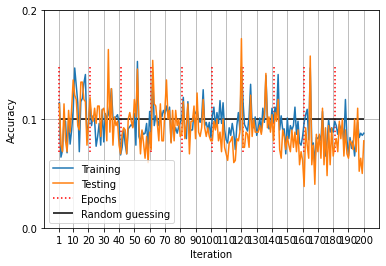

In [31]:
nn_plot_iter_acc(train_acc_dict["model_1"],
                 test_acc_dict["model_1"],
                 iteration_dict["model_1"],
                 mean_comparison = 0.1)

In [32]:
y_true, y_pred_begin = nn_class_pred_true(model_1, X_test, y_test, print_comp=True)

Prediction: 4, Actual: 7, False
Prediction: 2, Actual: 2, True
Prediction: 4, Actual: 1, False
Prediction: 2, Actual: 0, False
Prediction: 5, Actual: 4, False
Prediction: 5, Actual: 1, False
Prediction: 9, Actual: 4, False
Prediction: 2, Actual: 9, False
Prediction: 2, Actual: 5, False
Prediction: 9, Actual: 9, True
Prediction: 2, Actual: 0, False
Prediction: 2, Actual: 6, False
Prediction: 2, Actual: 9, False
Prediction: 2, Actual: 0, False
Prediction: 5, Actual: 1, False
Prediction: 2, Actual: 5, False
Prediction: 2, Actual: 9, False
Prediction: 2, Actual: 7, False
Prediction: 5, Actual: 3, False
Prediction: 9, Actual: 4, False
Prediction: 4, Actual: 9, False
Prediction: 9, Actual: 6, False
Prediction: 2, Actual: 6, False
Prediction: 2, Actual: 5, False
Prediction: 2, Actual: 4, False
Prediction: 2, Actual: 0, False
Prediction: 2, Actual: 7, False
Prediction: 2, Actual: 4, False
Prediction: 2, Actual: 0, False
Prediction: 4, Actual: 1, False
Prediction: 2, Actual: 3, False
Prediction

In [33]:
y_true, y_pred_end = nn_class_pred_true(model_dict["model_1"], X_test, y_test, print_comp=True)

Prediction: 8, Actual: 7, False
Prediction: 8, Actual: 2, False
Prediction: 8, Actual: 1, False
Prediction: 8, Actual: 0, False
Prediction: 8, Actual: 4, False
Prediction: 8, Actual: 1, False
Prediction: 8, Actual: 4, False
Prediction: 8, Actual: 9, False
Prediction: 8, Actual: 5, False
Prediction: 8, Actual: 9, False
Prediction: 8, Actual: 0, False
Prediction: 8, Actual: 6, False
Prediction: 8, Actual: 9, False
Prediction: 8, Actual: 0, False
Prediction: 8, Actual: 1, False
Prediction: 8, Actual: 5, False
Prediction: 8, Actual: 9, False
Prediction: 8, Actual: 7, False
Prediction: 8, Actual: 3, False
Prediction: 8, Actual: 4, False
Prediction: 8, Actual: 9, False
Prediction: 8, Actual: 6, False
Prediction: 8, Actual: 6, False
Prediction: 8, Actual: 5, False
Prediction: 8, Actual: 4, False
Prediction: 8, Actual: 0, False
Prediction: 8, Actual: 7, False
Prediction: 8, Actual: 4, False
Prediction: 8, Actual: 0, False
Prediction: 8, Actual: 1, False
Prediction: 8, Actual: 3, False
Predicti

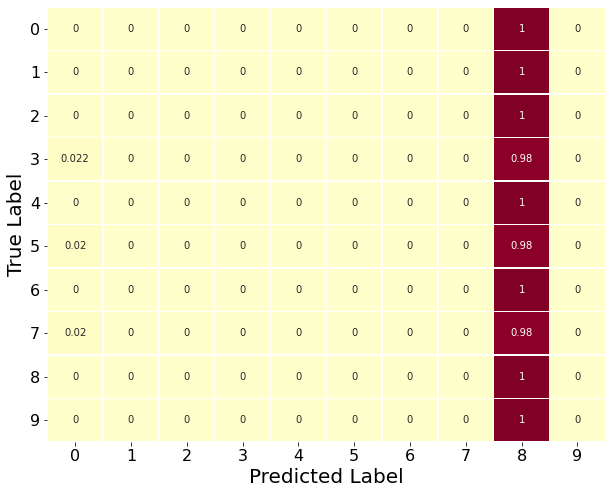

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.02222222, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.97777778, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.02      , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.98      , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.02040816, 0.        , 0.       

In [34]:
nn_conf_mat(y_true, y_pred_end)

In [35]:
y_pred_begin == y_pred_end

False